In [1]:
%reload_ext autoreload
%autoreload 2
import spikeinterface as si
import spikeinterface.extractors as se 
import spikeinterface.preprocessing as spre
import spikeinterface.sorters as ss
import spikeinterface.postprocessing as spost
import spikeinterface.qualitymetrics as sqm
import spikeinterface.comparison as sc
import spikeinterface.exporters as sexp
import spikeinterface.curation as scur
import spikeinterface.widgets as sw
from spikeinterface.exporters import export_to_phy
print(f"SpikeInterface version: {si.__version__}")
import probeinterface as pi
from probeinterface import Probe, ProbeGroup
from probeinterface.plotting import plot_probe, plot_probegroup 

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from pathlib import Path
import glob
import os, sys
import pickle, h5py
import re
from datetime import datetime
import shutil
from joblib import Parallel, delayed

from scipy.io import loadmat
from utils.data_io import select_folder, extract_datetime, create_channel_map, get_sampling_rate
# Note: If importing fails, please restart the kernel to refresh the module.

n_cpus = os.cpu_count()
n_jobs = n_cpus - 6
job_kwargs = dict(n_jobs=n_jobs, progress_bar=True)

SpikeInterface version: 0.103.2


In [2]:
# Path setup
basepath = "/local/workdir/ys2375/data/ayadataB1/data/hpc_ctx_project/HP15/hp15_day3_20241129"
# basepath = select_folder(initial_drive="V:\\")
base_dir = Path(basepath)

# Output directory
outputDir = Path(os.getcwd() + "/sorting_temp") / base_dir.name
outputDir.mkdir(parents=True, exist_ok=True)

# XML: Copy amplifier.xml from parent to base_dir as [dirname].xml
xmlPath = base_dir / f"{base_dir.name}.xml"
# src_xml = base_dir.parent / "amplifier.xml"
# if src_xml.exists() and not xmlPath.exists():
#     shutil.copy2(src_xml, xmlPath)

# Find recording files 
# dataPath = sorted(list(base_dir.glob("*.dat")))
dataPath = sorted(glob.glob(str(base_dir / "*/amplifier.dat")), key=extract_datetime)

print(f"XML path: {xmlPath}")
print(f"Recording files paths: {str(dataPath)}")
print(f"Output directory: {outputDir}")

XML path: /local/workdir/ys2375/data/ayadataB1/data/hpc_ctx_project/HP15/hp15_day3_20241129/hp15_day3_20241129.xml
Recording files paths: ['/local/workdir/ys2375/data/ayadataB1/data/hpc_ctx_project/HP15/hp15_day3_20241129/hp15_probe_241229_123627/amplifier.dat', '/local/workdir/ys2375/data/ayadataB1/data/hpc_ctx_project/HP15/hp15_day3_20241129/hp15_presleep_241229_124602/amplifier.dat', '/local/workdir/ys2375/data/ayadataB1/data/hpc_ctx_project/HP15/hp15_day3_20241129/hp15_cheeseboard_241229_144951/amplifier.dat', '/local/workdir/ys2375/data/ayadataB1/data/hpc_ctx_project/HP15/hp15_day3_20241129/hp15_postsleep_241229_155214/amplifier.dat']
Output directory: /local/workdir/ys2375/PreprocessPipeline/sorting_temp/hp15_day3_20241129


(<matplotlib.collections.PolyCollection at 0x7f64b0f00f90>, None)

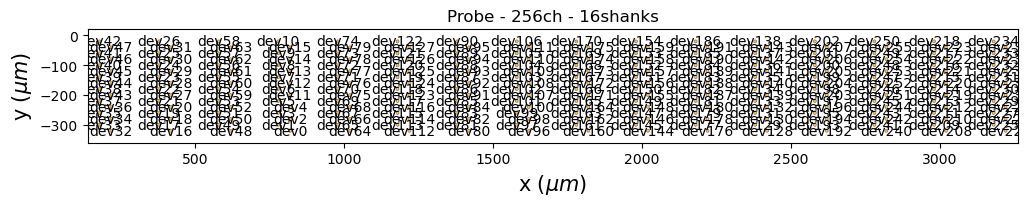

In [3]:
chanMapPath = glob.glob(basepath + '/chanMap.mat')[0]
chanMapmat_correct = loadmat(chanMapPath)
x = chanMapmat_correct['xcoords'].flatten()
y = chanMapmat_correct['ycoords'].flatten()
coords = np.column_stack((x, y))
shank_ids = chanMapmat_correct['kcoords'].flatten()
device_ch_inds = chanMapmat_correct['chanMap'].flatten() - 1
# bad_ch_ids = np.where(chanMapmat_correct['connected'][:,0]==0)[0]
bad_ch_ids = []

probe = Probe(ndim=2, si_units='um')
probe.set_contacts(
    positions=coords,
    shapes='circle',
    shape_params={'radius': 5},
    shank_ids=shank_ids
)
probe.set_device_channel_indices(device_ch_inds)

fig, ax = plt.subplots(figsize=(12,4)) 
plot_probe(probe, with_contact_id=True, with_device_index=True, ax=ax)

In [ ]:
# Sampling frequency and channel count
fs = get_sampling_rate(xmlPath)
num_channels = len(device_ch_inds)
recording_list = []

# Read and load each binary recording file
for i in range(len(dataPath)):
    recording_ = se.read_binary(
        dataPath[i],
        sampling_frequency=fs,
        dtype='int16',
        num_channels=num_channels,
        gain_to_uV=0.195,
        offset_to_uV=0
    )
    print(dataPath[i])
    recording_list.append(recording_)

# Concatenate all recordings into single recording object
recording = si.concatenate_recordings(recording_list)
# Extract the last directory name and save recording using write_binary_recording
file_name = Path(basepath).name + '.dat'
final_dat_path = Path(outputDir) / file_name

# Write concatenated binary recording with desired filename
if not final_dat_path.exists():
    si.write_binary_recording(
        recording,
        file_paths=str(final_dat_path),
        add_file_extension=False,
        verbose=True,
        **job_kwargs
    )
    print(f"Saved to: {final_dat_path}")
else:
    print(f"File already exists: {final_dat_path}")